In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
from google.colab import files

In [30]:
df = pd.read_csv("cleaned_df.csv")

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1226 entries, 0 to 1225
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1226 non-null   object
 1   Age                        1226 non-null   int64 
 2   Gender                     1226 non-null   object
 3   Country                    1226 non-null   object
 4   state                      1226 non-null   object
 5   self_employed              1226 non-null   object
 6   family_history             1226 non-null   object
 7   treatment                  1226 non-null   object
 8   work_interfere             1226 non-null   object
 9   no_employees               1226 non-null   object
 10  remote_work                1226 non-null   object
 11  tech_company               1226 non-null   object
 12  benefits                   1226 non-null   object
 13  care_options               1226 non-null   object
 14  wellness

In [32]:
df.isnull().sum()

,0
Timestamp,0
Age,0
Gender,0
Country,0
state,0
self_employed,0
family_history,0
treatment,0
work_interfere,0
no_employees,0


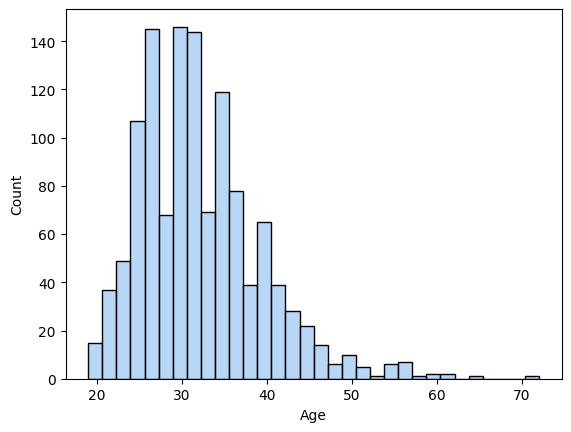

In [33]:
colors = sns.color_palette('pastel')
sns.histplot(df['Age'], color=colors[0])
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


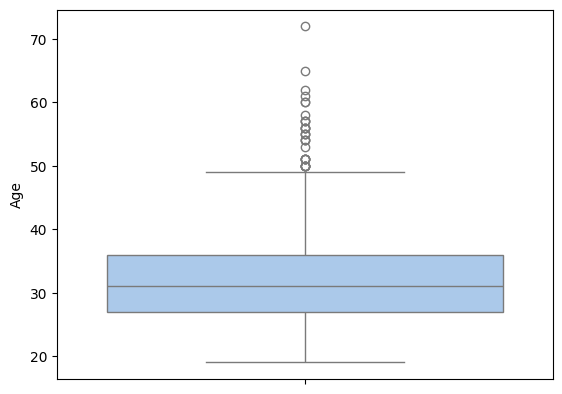

In [34]:
sns.boxplot(df['Age'], color=colors[0])
plt.show()

In [35]:
bins = [18, 25, 35, 45, 55, 65, 100]
labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '66 and older']
df['Age_group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
treatment_by_age_group = df.groupby('Age_group')['treatment'].value_counts(normalize=True).unstack()
treatment_by_age_group_melted = treatment_by_age_group.reset_index().melt(id_vars='Age_group')


<ipython-input-35-aef5ad661787>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  treatment_by_age_group = df.groupby('Age_group')['treatment'].value_counts(normalize=True).unstack()


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


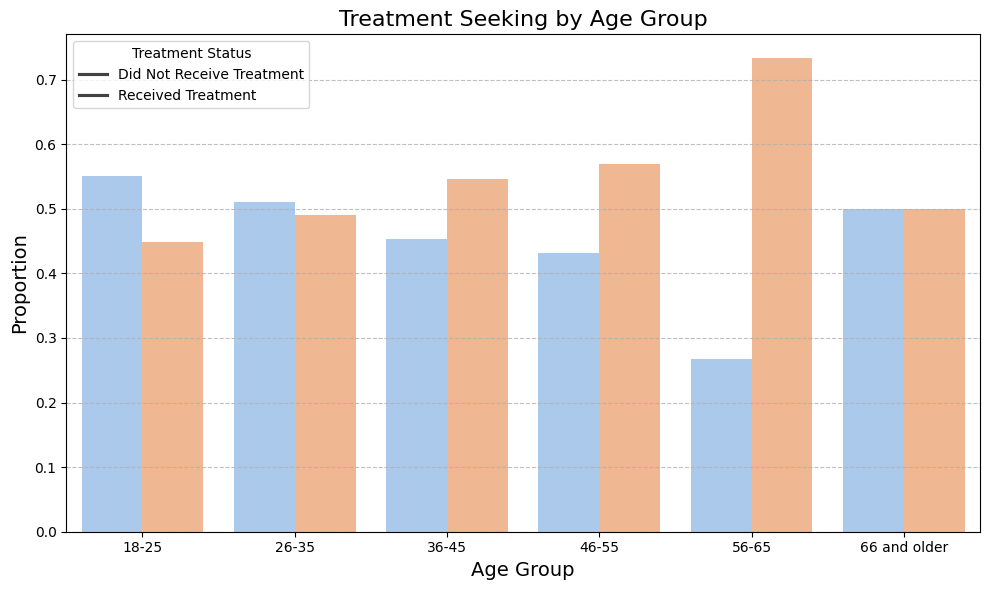

In [36]:
treatment_labels = ['Did Not Receive Treatment', 'Received Treatment']

plt.figure(figsize=(10, 6))
sns.barplot(data=treatment_by_age_group_melted, x='Age_group', y='value', hue='treatment', palette='pastel')

plt.title('Treatment Seeking by Age Group', fontsize=16)
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.xticks(rotation=0)

plt.grid(axis='y', linestyle='--', linewidth=0.8, alpha=0.8)

treatment_labels = ['Did Not Receive Treatment', 'Received Treatment']
plt.legend(title='Treatment Status', labels=treatment_labels)
plt.tight_layout()
plt.show()

In [37]:
df.columns

Index(['Timestamp', 'Age', 'Gender', 'Country', 'state', 'self_employed',
       'family_history', 'treatment', 'work_interfere', 'no_employees',
       'remote_work', 'tech_company', 'benefits', 'care_options',
       'wellness_program', 'seek_help', 'anonymity', 'leave',
       'mental_health_consequence', 'phys_health_consequence', 'coworkers',
       'supervisor', 'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence', 'comments',
       'Standardized_gender', 'Age_group'],
      dtype='object')

In [38]:
df['Standardized_gender'].value_counts().index

Index(['male', 'female', 'other'], dtype='object', name='Standardized_gender')

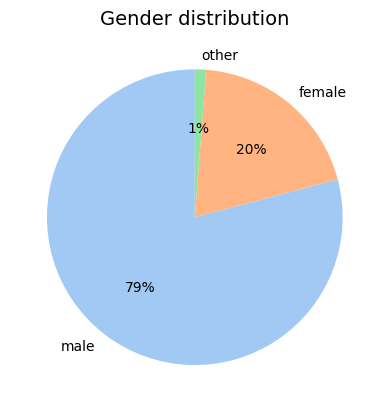

In [39]:
colors = sns.color_palette('pastel')

values = df['Standardized_gender'].value_counts().values
labels = df['Standardized_gender'].value_counts().index

plt.pie(values,
        labels=labels,
        autopct='%1.0f%%',
        startangle=90,
        colors=colors)

plt.title('Gender distribution', fontsize=14)
plt.show()


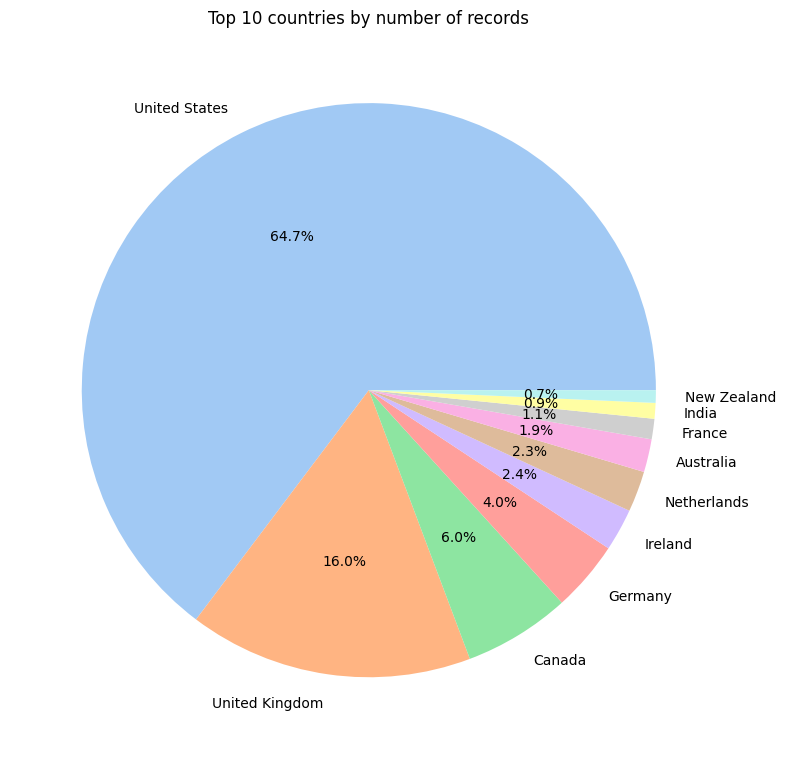

In [40]:
top_countries = df['Country'].value_counts().head(10)


plt.figure(figsize=(8,8))
plt.pie(top_countries, labels=top_countries.index, colors=colors, autopct='%1.1f%%')
plt.title('Top 10 countries by number of records')
plt.tight_layout()
plt.show()

In [41]:
top_countries_indexes = df['Country'].value_counts().head(10).index
filtered_df = df[df['Country'].isin(top_countries_indexes)]
treatment_percent = filtered_df.groupby("Country")['treatment'].value_counts(normalize=True).unstack()['Yes']*100

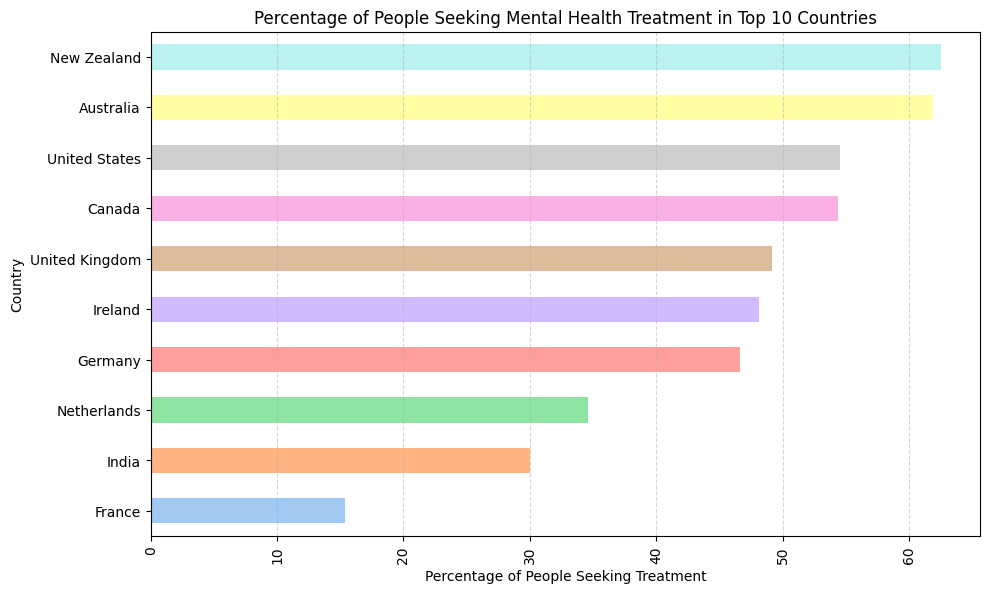

In [42]:
plt.figure(figsize=(10,6))
treatment_percent.sort_values().plot(kind='barh', color=colors)
plt.xlabel('Percentage of People Seeking Treatment')
plt.title('Percentage of People Seeking Mental Health Treatment in Top 10 Countries')
plt.tight_layout()
plt.grid(axis='x', alpha=0.5, linestyle ='--')
plt.xticks(rotation=90)
plt.show()

In [43]:
treatment_by_country = df.groupby('Country')['treatment'].value_counts(normalize=True).unstack()
data=treatment_by_country_melted = treatment_by_country.reset_index().melt(id_vars='Country')

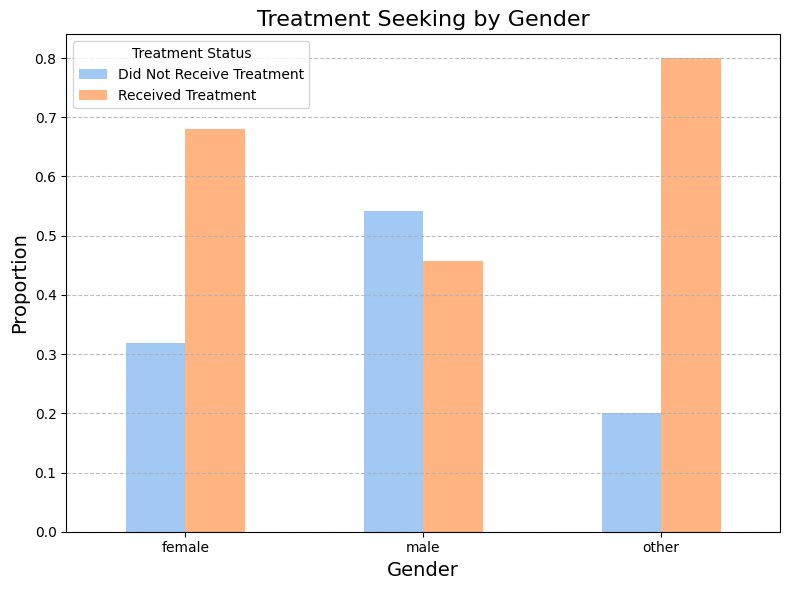

In [44]:
treatment_by_gender = df.groupby('Standardized_gender')['treatment'].value_counts(normalize=True).unstack().fillna(0)
treatment_by_gender.plot(kind='bar', stacked=False, color=sns.color_palette('pastel'), figsize=(8, 6))

plt.title('Treatment Seeking by Gender', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.xticks(rotation=0)

plt.grid(axis='y', linestyle='--', linewidth=0.8, alpha=0.8)

plt.legend(title='Treatment Status', labels=treatment_labels)
plt.tight_layout()
plt.show()

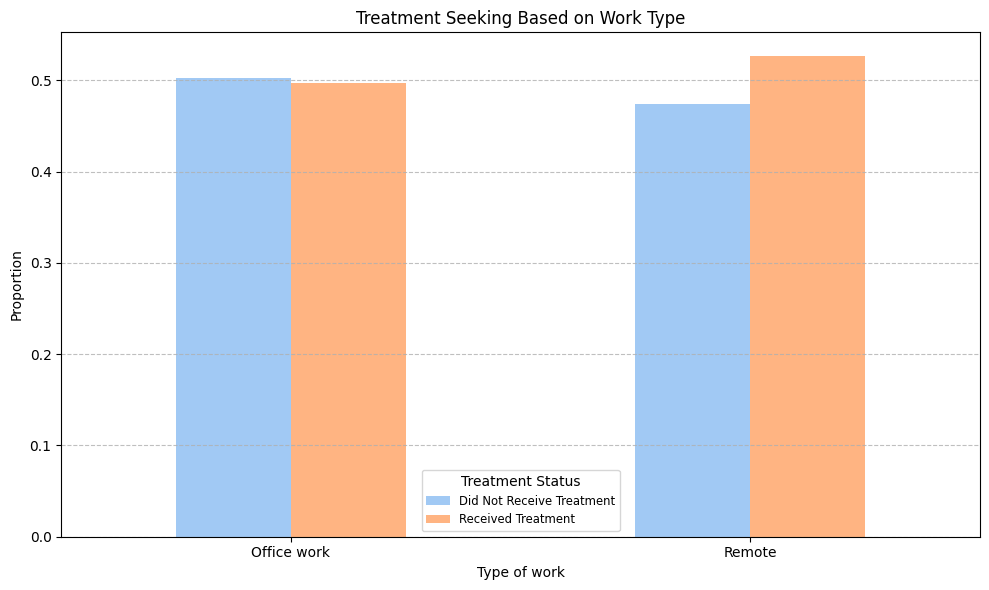

In [45]:
treatment_by_type_work = df.groupby('remote_work')['treatment'].value_counts(normalize=True).unstack()
treatment_by_type_work.plot(kind='bar', stacked=False, color=sns.color_palette('pastel'), figsize=(10, 6))

plt.title('Treatment Seeking Based on Work Type')
plt.xlabel('Type of work')
plt.ylabel('Proportion')
plt.xticks(rotation=0)

plt.gca().set_xticklabels(['Office work', 'Remote'])

plt.grid(axis='y', linestyle='--', linewidth=0.8, alpha=0.8)

plt.legend(title='Treatment Status', labels=treatment_labels, fontsize='small')
plt.tight_layout()
plt.show()

<ipython-input-46-8d930585b0de>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=family_history_count.index, y=family_history_count.values, palette='pastel')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


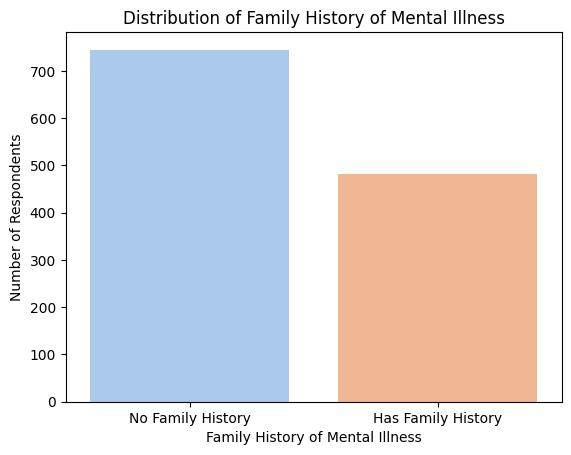

In [46]:
family_history_count = df['family_history'].replace({'Yes': 'Has Family History', 'No': 'No Family History'}).value_counts()

sns.barplot(x=family_history_count.index, y=family_history_count.values, palette='pastel')
plt.title('Distribution of Family History of Mental Illness')
plt.xlabel('Family History of Mental Illness')
plt.ylabel('Number of Respondents')
plt.show()

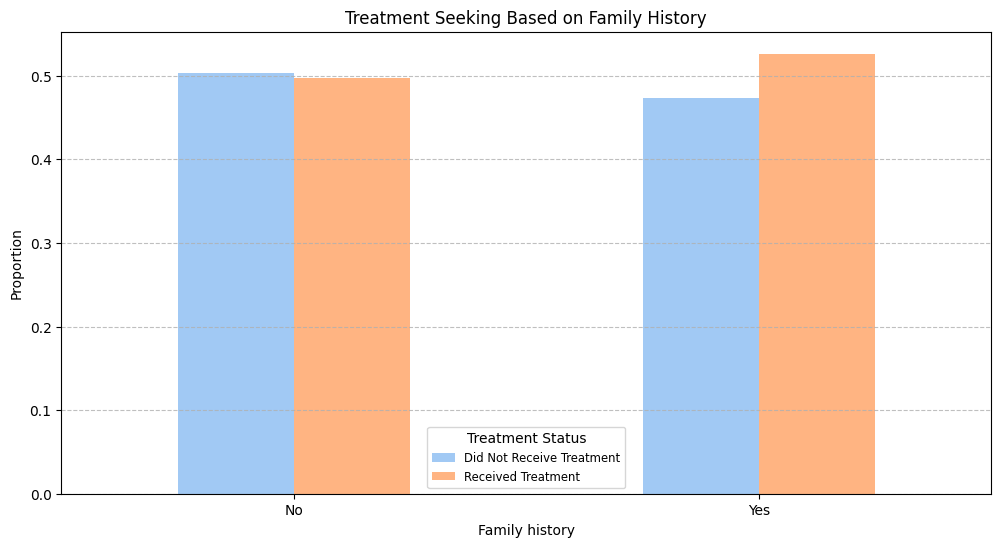

In [47]:
treatment_by_family_hist = df.groupby('family_history')['treatment'].value_counts(normalize=True).unstack()
treatment_by_type_work.plot(kind='bar', stacked=False, color=sns.color_palette('pastel'), figsize=(12, 6))

plt.grid(axis='y', linestyle='--', linewidth=0.8, alpha=0.8)

plt.title('Treatment Seeking Based on Family History')
plt.xlabel('Family history')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(title='Treatment Status', labels=treatment_labels, fontsize='small')

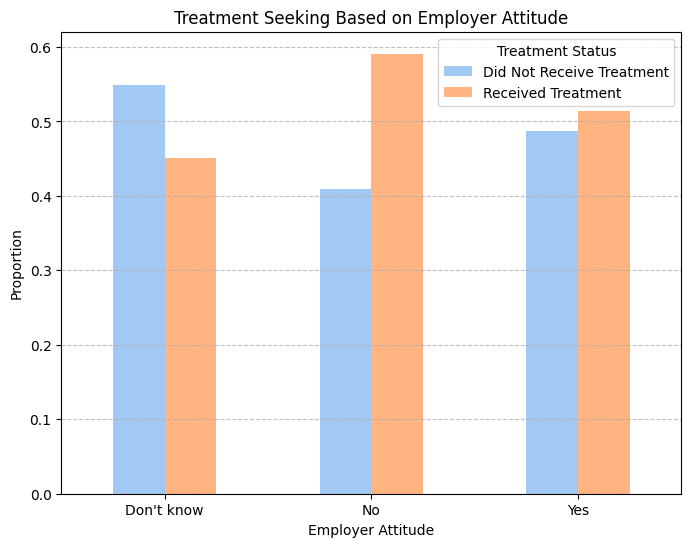

In [48]:
treatment_by_employer_attitude = df.groupby('mental_vs_physical')['treatment'].value_counts(normalize=True).unstack()
treatment_by_employer_attitude.plot(kind='bar', stacked=False, color=sns.color_palette('pastel'), figsize=(8, 6))

plt.grid(axis='y', linestyle='--', linewidth=0.8, alpha=0.8)

plt.title('Treatment Seeking Based on Employer Attitude')
plt.xlabel('Employer Attitude')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(title='Treatment Status', labels=treatment_labels)
plt.show()

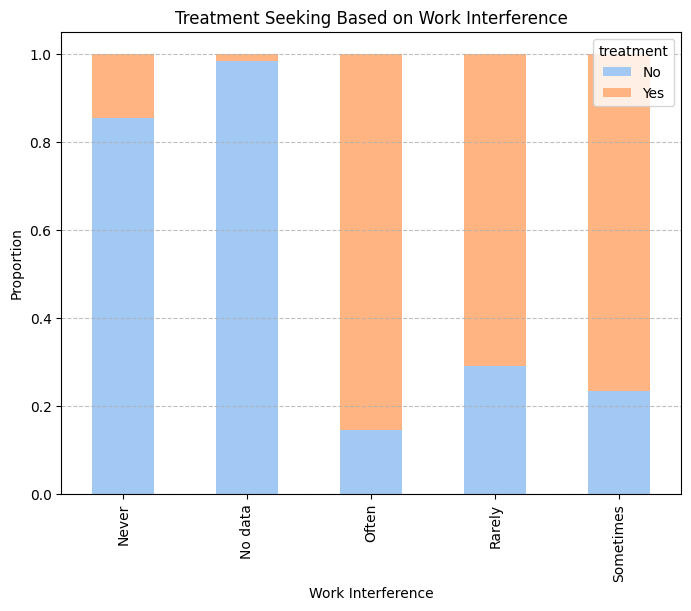

In [49]:
work_interfere_treatment = df.groupby('work_interfere')['treatment'].value_counts(normalize=True).unstack().fillna(0)
work_interfere_treatment.plot(kind='bar', stacked=True, color=sns.color_palette('pastel'), figsize=(8, 6))
plt.title('Treatment Seeking Based on Work Interference')
plt.xlabel('Work Interference')
plt.ylabel('Proportion')
plt.grid(axis='y', linestyle='--', linewidth=0.8, alpha=0.8)
plt.show()


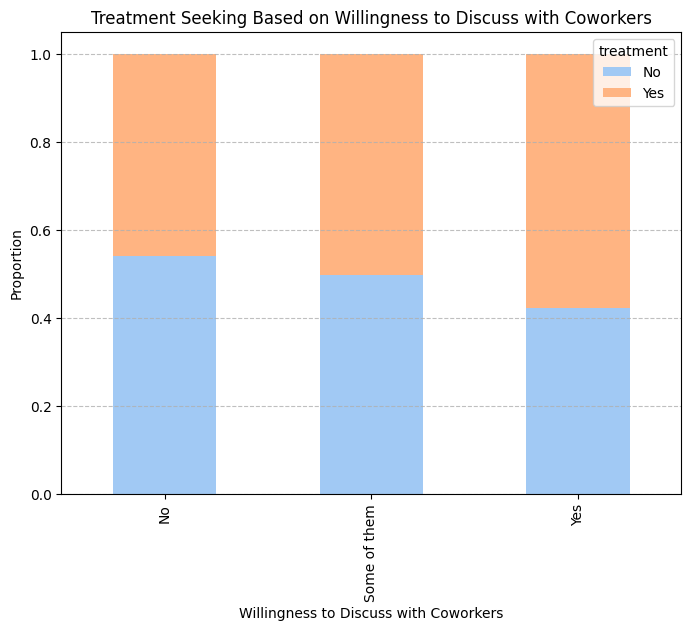

In [50]:
coworkers_treatment = df.groupby('coworkers')['treatment'].value_counts(normalize=True).unstack().fillna(0)
coworkers_treatment.plot(kind='bar', stacked=True, color=sns.color_palette('pastel'), figsize=(8, 6))
plt.title('Treatment Seeking Based on Willingness to Discuss with Coworkers')
plt.xlabel('Willingness to Discuss with Coworkers')
plt.ylabel('Proportion')
plt.grid(axis='y', linestyle='--', linewidth=0.8, alpha=0.8)
plt.show()


In [51]:
selected_features = ['Age', 'Standardized_gender', 'self_employed', 'family_history', 'work_interfere',
                     'no_employees', 'remote_work', 'tech_company', 'benefits',
                     'care_options', 'wellness_program', 'seek_help', 'anonymity',
                     'leave', 'mental_health_consequence', 'phys_health_consequence',
                     'coworkers', 'supervisor', 'mental_health_interview',
                     'phys_health_interview', 'mental_vs_physical', 'obs_consequence']

df_selected = df[selected_features + ['treatment']]

categorical_columns = ['Standardized_gender', 'self_employed', 'family_history', 'work_interfere',
                       'no_employees', 'remote_work', 'tech_company', 'benefits',
                       'care_options', 'wellness_program', 'seek_help', 'anonymity',
                       'leave', 'mental_health_consequence', 'phys_health_consequence',
                       'coworkers', 'supervisor', 'mental_health_interview',
                       'phys_health_interview', 'mental_vs_physical', 'obs_consequence']
df_encoded = pd.get_dummies(df_selected, columns=categorical_columns)

scaler = MinMaxScaler()

# Нормализуем столбец Age
df_encoded['Age'] = scaler.fit_transform(df_encoded[['Age']])

In [52]:
# Проверяем наличие нечисловых данных в DataFrame
print(df_encoded.select_dtypes(include=['object']).columns)

Index(['treatment'], dtype='object')


In [53]:
# Преобразуем 'treatment' из строковых значений в бинарные (0 и 1)
df_encoded['treatment'] = df_encoded['treatment'].map({'Yes': 1, 'No': 0})


In [54]:
X = df_encoded.drop('treatment', axis=1)
y= df_encoded['treatment']
# Применяем критерий хи-квадрат
chi2_values, p_values = chi2(X, y)

chi2_results = pd.DataFrame({'Feature': X.columns, 'Chi2': chi2_values, 'p-value': p_values})

# Сортируем результаты по p-value
chi2_results = chi2_results.sort_values(by='p-value')
print(chi2_results)


                     Feature        Chi2       p-value
9     work_interfere_No data  250.067968  2.509701e-56
12  work_interfere_Sometimes  124.303807  7.228411e-29
8       work_interfere_Never  105.913101  7.704060e-25
7         family_history_Yes  105.738447  8.413897e-25
6          family_history_No   68.268715  1.426665e-16
..                       ...         ...           ...
15       no_employees_26-100    0.119367  7.297215e-01
63    mental_vs_physical_Yes    0.079939  7.773805e-01
50    coworkers_Some of them    0.058697  8.085670e-01
42           leave_Very easy    0.053820  8.165445e-01
4           self_employed_No    0.037537  8.463757e-01

[66 rows x 3 columns]


In [55]:
# Фильтруем признаки с p-value меньше 0.05
significant_features = chi2_results[chi2_results['p-value'] < 0.05]

significant_feature_names = significant_features['Feature'].tolist()

# Создаем новый DataFrame с значимыми признаками и целевой переменной
df_significant = df_encoded[significant_feature_names + ['treatment']]


df_significant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1226 entries, 0 to 1225
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   work_interfere_No data         1226 non-null   bool 
 1   work_interfere_Sometimes       1226 non-null   bool 
 2   work_interfere_Never           1226 non-null   bool 
 3   family_history_Yes             1226 non-null   bool 
 4   family_history_No              1226 non-null   bool 
 5   work_interfere_Often           1226 non-null   bool 
 6   care_options_Yes               1226 non-null   bool 
 7   benefits_Yes                   1226 non-null   bool 
 8   Standardized_gender_female     1226 non-null   bool 
 9   benefits_Don't know            1226 non-null   bool 
 10  work_interfere_Rarely          1226 non-null   bool 
 11  obs_consequence_Yes            1226 non-null   bool 
 12  care_options_No                1226 non-null   bool 
 13  anonymity_Yes     

In [56]:
df_significant.to_csv('df_significant.csv', index=False)
files.download('df_significant.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>